Importing Libraries

In [3]:
import cv2
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard, LearningRateScheduler
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.gridspec as gridspec
from PIL import Image

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action = 'ignore')

Data Import and Loading

In [4]:
data_dir = 'datasets/'
train_dir = os.path.join(data_dir, "Training")
test_dir = os.path.join(data_dir, "Testing")
val_dir = os.path.join(data_dir, "Validation")

In [5]:
CATEGORIES = ["glioma", "meningioma", "notumor", "pituitary"]
num_of_categories = len(CATEGORIES)

In [6]:
def data_info(data_dir):
    for category in CATEGORIES:
        print(f'{category} images: {len(os.listdir(os.path.join(data_dir, category)))}')

In [7]:
print("\nTraining Dataset: \n")
data_info(train_dir)
print("\nTesting Dataset: \n")
data_info(test_dir)
print("\nValidation Dataset: \n")
data_info(val_dir)



Training Dataset: 

glioma images: 1321
meningioma images: 1339
notumor images: 1595
pituitary images: 1457

Testing Dataset: 

glioma images: 274
meningioma images: 306
notumor images: 405
pituitary images: 300

Validation Dataset: 

glioma images: 175
meningioma images: 139
notumor images: 162
pituitary images: 179


Data Preprocessing

In [8]:
def data_preparation(data, subpath_dir, dataset_dir):
    data_list = []
    #Tumor type
    for category_id, category in enumerate(CATEGORIES):
        #Main directiory + tumor type
        category_dir = os.path.join(dataset_dir, category) 
        
        #List of images
        for file in os.listdir(category_dir):
            data_list.append([f'{data_dir}/{subpath_dir}/{category}/{file}', category_id, category])
    
    #Dataframe
    data = pd.DataFrame(data_list, columns = ['file', 'category_id', 'category'])
    print(f'Shape of {subpath_dir} dataset: {data.shape}')
    return data

In [9]:
train = pd.DataFrame()
trainset = data_preparation(train, "Training", train_dir)
trainset.head()

Shape of Training dataset: (5712, 3)


,file,category_id,category
0,datasets//Training/glioma/Tr-glTr_0000.jpg,0,glioma
1,datasets//Training/glioma/Tr-glTr_0001.jpg,0,glioma
2,datasets//Training/glioma/Tr-glTr_0002.jpg,0,glioma
3,datasets//Training/glioma/Tr-glTr_0003.jpg,0,glioma
4,datasets//Training/glioma/Tr-glTr_0004.jpg,0,glioma


In [10]:
test = pd.DataFrame()
testset = data_preparation(test, "Testing", test_dir)
testset.head()

Shape of Testing dataset: (1285, 3)


,file,category_id,category
0,datasets//Testing/glioma/Te-gl_0026.jpg,0,glioma
1,datasets//Testing/glioma/Te-gl_0027.jpg,0,glioma
2,datasets//Testing/glioma/Te-gl_0028.jpg,0,glioma
3,datasets//Testing/glioma/Te-gl_0029.jpg,0,glioma
4,datasets//Testing/glioma/Te-gl_0030.jpg,0,glioma


In [11]:
val = pd.DataFrame()
valset = data_preparation(val, "Validation", val_dir)
valset.head()

Shape of Validation dataset: (655, 3)


,file,category_id,category
0,datasets//Validation/glioma/Tr-glTr_0001.jpg,0,glioma
1,datasets//Validation/glioma/Tr-glTr_0002.jpg,0,glioma
2,datasets//Validation/glioma/Tr-glTr_0003.jpg,0,glioma
3,datasets//Validation/glioma/Tr-glTr_0004.jpg,0,glioma
4,datasets//Validation/glioma/Tr-glTr_0005.jpg,0,glioma


In [12]:
trainset['category'].value_counts()

category
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64

In [13]:
SAMPLE_PER_CATEGORIES = 1321
SEED = 42
WIDTH = 224
HEIGHT = 224
DEPTH = 3
INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)

**Randomization**

In [14]:
def randomize_data(data, sample_per_category):
    """Randomizes and balances the dataset."""
    data = pd.concat([data[data['category'] == c][:sample_per_category] for c in CATEGORIES])
    data = data.sample(frac=1, random_state=SEED).reset_index(drop=True)
    return data

In [15]:
training = randomize_data(trainset, SAMPLE_PER_CATEGORIES)
validing = valset.copy()
testing = testset.copy()

Exploratory Data Analysis

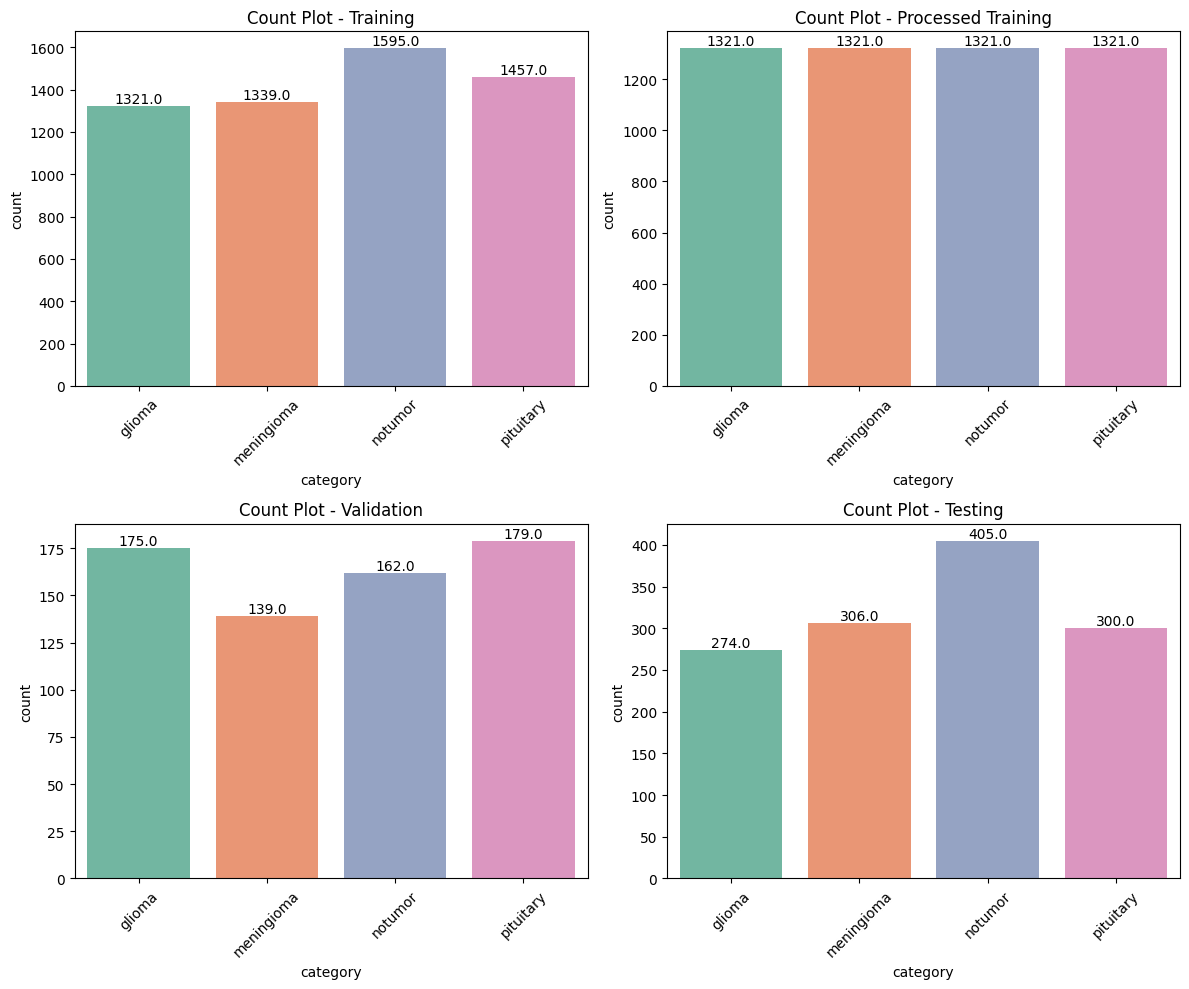

In [16]:
def plot_countplots(train, processed_train, val, test, categories):
    """Plots count plots for the datasets."""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    datasets = [train, processed_train, val, test]
    dataset_names = ["Training", "Processed Training", "Validation", "Testing"]
    for i, ax in enumerate(axes.flat):
        sns.countplot(data=datasets[i], x='category', ax=ax, palette="Set2")
        ax.set_title(f'Count Plot - {dataset_names[i]}')
        ax.set_xticklabels(categories, rotation=45)
        for p in ax.patches:
            ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

plot_countplots(trainset, training, validing, testing, CATEGORIES)   

Image Visualization

In [17]:
def read_img(filepath, size):
    img = image.load_img(filepath, target_size = size)
    img = image.img_to_array(img)
    return img
    

In [18]:
def visualize_images(data, title):
    """Visualizes sample images from each category."""
    fig = plt.figure(1, figsize=(8, 8))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    i = 0
    for category_id, category in enumerate(CATEGORIES):
        for filepath in data[data['category'] == category]['file'].values[:num_of_categories]:
            ax = grid[i]
            img = read_img(filepath, (WIDTH, HEIGHT))
            ax.imshow(img / 255.0)
            ax.axis('on')
            if i % num_of_categories == num_of_categories - 1:
                ax.text(250, 112, filepath.split('/')[-2], verticalalignment='center')
            i += 1
    plt.suptitle(title)
    plt.show()

Testing Image Data

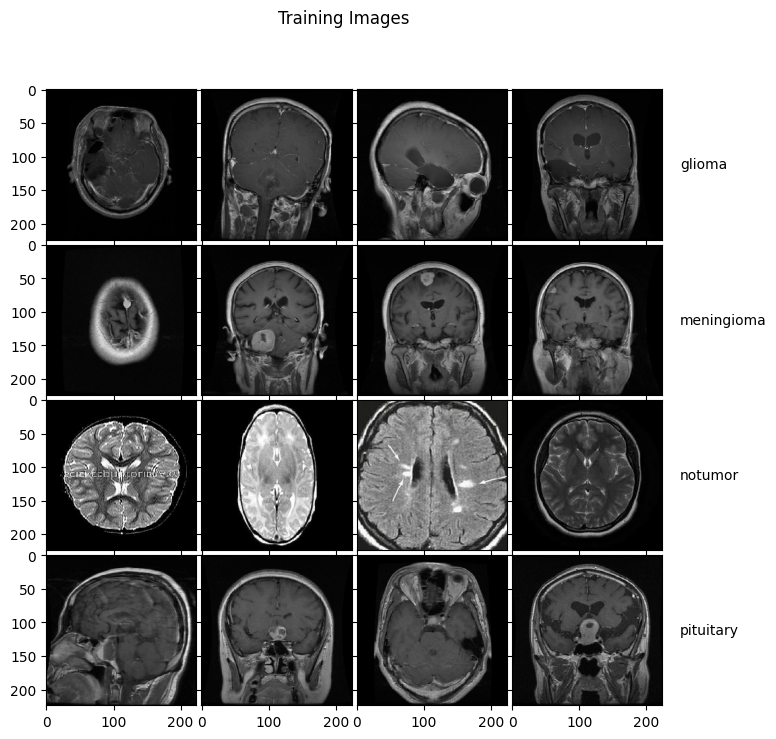

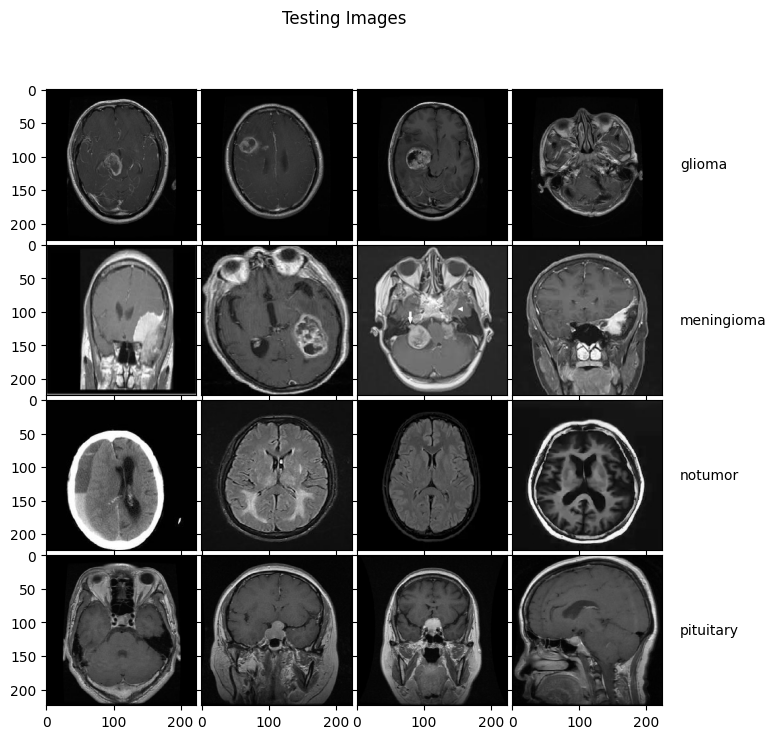

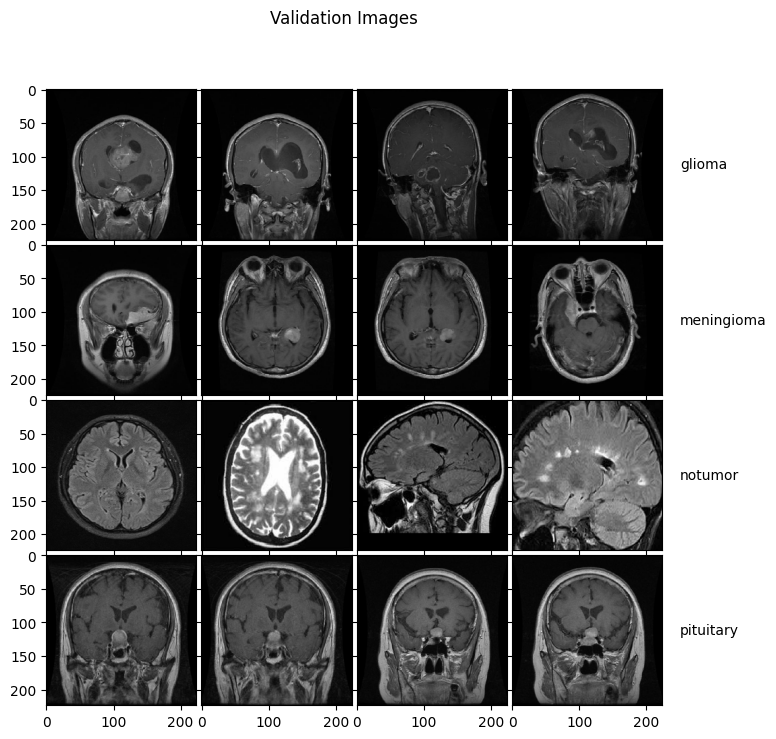

In [19]:
visualize_images(training, "Training Images")
visualize_images(testing, "Testing Images")
visualize_images(validing, "Validation Images")

Image Data Generation for Augmentation

In [20]:
def prepare_the_dataset(train_dataframe, val_dataframe, x_columns, y_column, batch_size, image_size):
    train_image_data_generator = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest'
    )
    
    val_image_data_generator = ImageDataGenerator(rescale = 1./255)
    
    train_generator = train_image_data_generator.flow_from_dataframe(
        batch_size = batch_size,
        dataframe = train_dataframe,
        shuffle = True,
        x_col = x_columns,
        y_col = y_column,
        target_size = (image_size, image_size),
        class_mode = 'categorical'
    )
    
    val_generator = val_image_data_generator.flow_from_dataframe(
        batch_size = batch_size,
        dataframe = val_dataframe,
        shuffle = True,
        x_col = x_columns,
        y_col = y_column,
        target_size = (image_size, image_size),
        class_mode = 'categorical'
    )
    
    return train_generator, val_generator

In [21]:
train_dataframe = training
val_dataframe = testing
x_columns = 'file'
y_column = 'category'
batch_size = 128
image_size = 224

train_data_gen, val_data_gen = prepare_the_dataset(train_dataframe, val_dataframe, x_columns, y_column, batch_size, image_size)

Found 5284 validated image filenames belonging to 4 classes.
Found 1285 validated image filenames belonging to 4 classes.


In [22]:
def build_model(input_shape, num_classes):
    """Builds and compiles the CNN model."""
    pre_trained_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    for layer in pre_trained_model.layers:
        layer.trainable = False
    x = pre_trained_model.output
    x = Flatten()(x)
    x = Dense(2048, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=pre_trained_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [23]:
model = build_model(INPUT_SHAPE, num_of_categories)

In [24]:
checkpoint = ModelCheckpoint('best_brain_tumor_model.keras',
                             monitor = 'val_loss',
                             mode = 'min',
                             save_best_only = True,
                             verbose = 1)

early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        min_delta=0.0001,
                                        patience=3,
                                        verbose=1,
                                        restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.3,
                                       patience=1,
                                       verbose=1,
                                       min_delta=0.0001)

CALLBACKS = [checkpoint, early_stopping_callback, reduce_lr_callback]

Model Training

In [ ]:
nb_train_samples = len(train_dataframe)
nb_validation_samples = len(val_dataframe)
epochs = 15

history = model.fit(train_data_gen, 
                           steps_per_epoch = nb_train_samples // batch_size,
                           epochs = epochs,
                           callbacks = CALLBACKS,
                           validation_data = val_data_gen,
                           validation_steps = nb_validation_samples // batch_size,
                           shuffle = True)

In [26]:
# Model Evaluation
def plot_training_history(history):
    """Plots the training and validation accuracy and loss."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


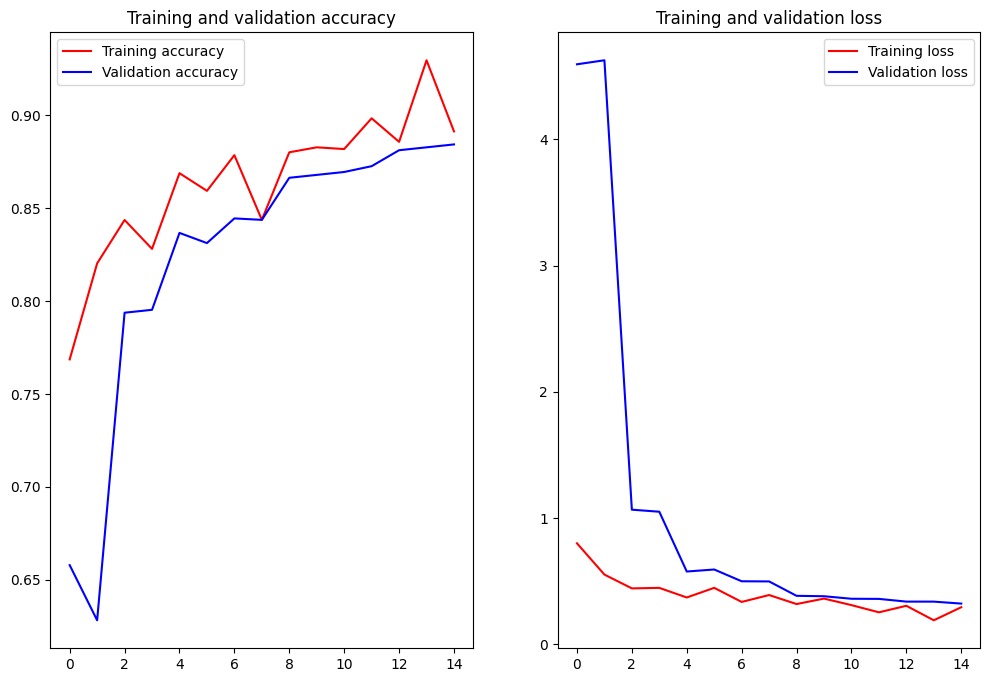

In [27]:
plot_training_history(history)

Model Prediction with Unseen Data (Validation)

In [28]:
def prepare_test_data(test_dataframe, x_columns, batch_size, image_size):  
    # Define parameters for ImageDataGenerator for train and validation

    test_image_data_generator = ImageDataGenerator(
        rescale=1./255  # Rescale pixel values to [0,1]
    )
    
    test_generator = test_image_data_generator.flow_from_dataframe(
        batch_size=batch_size,
        dataframe=test_dataframe,
        shuffle=False,
        x_col=x_columns,
        y_col=None,
        target_size=(image_size, image_size),  # Set the target size for images
        class_mode=None  # For categorical labels
    )
    return test_generator

In [29]:
test_processed_images = prepare_test_data(validing,'file', 32, 224)

Found 655 validated image filenames.


In [30]:
predictions = model.predict(test_processed_images, steps=len(testing) // 32 + 1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 300ms/step


In [31]:
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 1, 1, 0,
       0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1,
       3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1, 3, 1, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 0, 1, 3, 1, 3, 1,
       1, 3, 1, 0, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,

In [32]:
#Validing dataset to create new dataframe
target_and_predict = validing.copy()

In [33]:
#add column for predicted value
target_and_predict['predicted_classes'] = predicted_classes

In [34]:
target_and_predict

,file,category_id,category,predicted_classes
0,datasets//Validation/glioma/Tr-glTr_0001.jpg,0,glioma,0
1,datasets//Validation/glioma/Tr-glTr_0002.jpg,0,glioma,0
2,datasets//Validation/glioma/Tr-glTr_0003.jpg,0,glioma,0
3,datasets//Validation/glioma/Tr-glTr_0004.jpg,0,glioma,0
4,datasets//Validation/glioma/Tr-glTr_0005.jpg,0,glioma,0
...,...,...,...,...
650,datasets//Validation/pituitary/Tr-pi_1415.jpg,3,pituitary,3
651,datasets//Validation/pituitary/Tr-pi_1416.jpg,3,pituitary,3
652,datasets//Validation/pituitary/Tr-pi_1417.jpg,3,pituitary,3
653,datasets//Validation/pituitary/Tr-pi_1432.jpg,3,pituitary,1


In [35]:
accuracy = accuracy_score(target_and_predict['category_id'], target_and_predict['predicted_classes'])
print(f'Accuracy: {accuracy}')

Accuracy: 0.9145038167938931


ROC-AUC

In [36]:
unique_values = target_and_predict['category_id'].unique()
result = target_and_predict.groupby('category_id').first()
result


,file,category,predicted_classes
category_id,,,
0,datasets//Validation/glioma/Tr-glTr_0001.jpg,glioma,0
1,datasets//Validation/meningioma/Tr-meTr_0000.jpg,meningioma,1
2,datasets//Validation/notumor/Tr-noTr_0006.jpg,notumor,2
3,datasets//Validation/pituitary/Tr-piTr_0003.jpg,pituitary,3


In [37]:
result['category']


category_id
0        glioma
1    meningioma
2       notumor
3     pituitary
Name: category, dtype: object

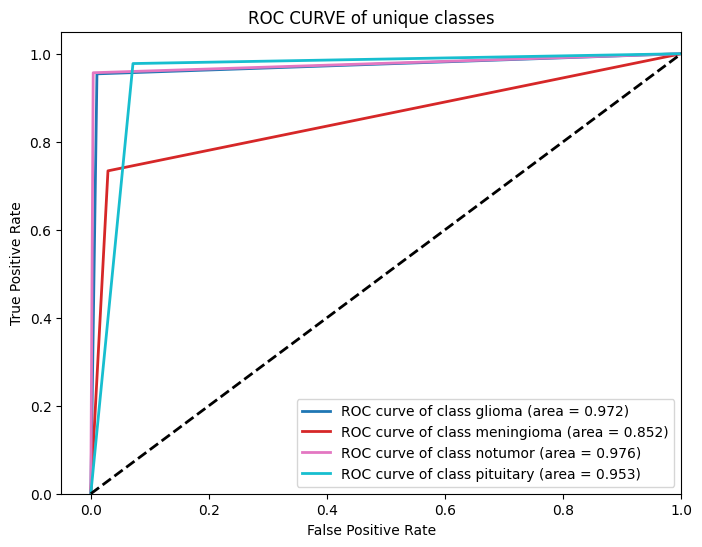

In [38]:
category_labels = ["glioma", "meningioma", "notumor", "pituitary"]

true_labels = target_and_predict['category_id']
predicted_classes_int = target_and_predict['predicted_classes']

y_test_bin = label_binarize(true_labels, classes=np.unique(true_labels))
y_pred_bin = label_binarize(predicted_classes_int, classes=np.unique(true_labels))

n_classes = len(category_labels)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    if np.sum(y_test_bin[:, i]) == 0 or np.sum(y_pred_bin[:, i]) == 0:
        print(f"Warning: Class {category_labels[i]} has no positive samples, skipping ROC curve.")
        continue

    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

lw = 2
plt.figure(figsize=(8, 6))
colors = plt.cm.tab10(np.linspace(0, 1, n_classes))

for i, color in zip(range(n_classes), colors):
    if i in fpr:
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label=f'ROC curve of class {category_labels[i]} (area = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE of unique classes')
plt.legend(loc="lower right")
plt.show()

In [40]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

classification_report_df = pd.DataFrame(classification_report(target_and_predict['category_id'], target_and_predict['predicted_classes'], output_dict=True)).transpose()
classification_report_df

,precision,recall,f1-score,support
0,0.970930,0.954286,0.962536,175.000000
1,0.871795,0.733813,0.796875,139.000000
2,0.987261,0.956790,0.971787,162.000000
3,0.837321,0.977654,0.902062,179.000000
accuracy,0.914504,0.914504,0.914504,0.914504
macro avg,0.916827,0.905636,0.908315,655.000000
weighted avg,0.917418,0.914504,0.913142,655.000000
